In [1]:
# LOAD ANY REQUIRED LIBRARIES

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# SETUP A PATH TO THE DATA

data_path = "./data/drifting_longlines.csv"

In [3]:
# LOAD THE DATA

df_data = pd.read_csv(data_path)

In [4]:
# HAVE A LOOK AT THE DATA STRUCTURE

df_data.head()

,vessel_num,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.260000e+13,1327136504,232994.2813,311748.6563,8.2,230.500000,14.865583,-26.853662,-1,dalhousie_longliner
1,1.260000e+13,1327136605,233994.2656,312410.3438,7.3,238.399994,14.863870,-26.856800,-1,dalhousie_longliner
2,1.260000e+13,1327136734,233994.2656,312410.3438,6.8,238.899994,14.861551,-26.860649,-1,dalhousie_longliner
3,1.260000e+13,1327143281,233994.2656,315417.3750,6.9,251.800003,14.822686,-26.865898,-1,dalhousie_longliner
4,1.260000e+13,1327143341,233996.3906,316172.5625,6.1,231.100006,14.821825,-26.867579,-1,dalhousie_longliner


## Preparation
Before we do any other work, let's coerce that timestamp into a datetime for easier understanding

In [5]:
df_data['datetime'] = df_data['timestamp'].apply(datetime.fromtimestamp)

# Vessels
Let's look at the number of distinct vessels and then the time span covered by the most common vessel.

In [6]:
df_data['vessel_num'].value_counts()

2.380000e+13    236842
1.180000e+14    225289
5.140000e+13    146687
8.130000e+13    100672
2.150000e+14     92842
7.720000e+13     84873
1.040000e+14     74585
2.570000e+14     43554
2.810000e+14     18096
1.680000e+14     13289
1.260000e+13     11846
Name: vessel_num, dtype: int64

We only have 11 distinct vessels in this data (unless the identifiers get recycled)


The most common Vessel (2.380000e+13) in the data appears 236,842 times


It seems like this multiple trips. Lets look at the timestamps to validate this.

In [7]:

df_temp = df_data[df_data['vessel_num']==2.380000e+13]

latest = max(df_temp['datetime'])
oldest = min(df_temp['datetime'])
print("Vessel data between ", oldest, " and ", latest )

Vessel data between  2012-02-27 03:23:14  and  2016-11-25 10:59:22


Ok, so this single Vessel has data for more than 4 years. It has to be multiple trips, we need to work out how to break these into individual voyages?

We may need to parse the data per vessel and look for long gaps between timestamps in order to generate a voyage identifier for each distinct trip made by that vessel.

First, lets look at the distribution of differences between timestamps

In [8]:
df_data['previous_datetime'] = df_data.sort_values(by=['datetime'], ascending=True)\
    .groupby(['vessel_num'])['datetime'].shift(1)

In [9]:
def get_timedelta_secs(x):
    return (x['datetime'] - x['previous_datetime']).seconds

df_data['timedelta']  = df_data.apply(get_timedelta_secs, axis=1)

In [10]:
df_data.head()

,vessel_num,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,datetime,previous_datetime,timedelta
0,1.260000e+13,1327136504,232994.2813,311748.6563,8.2,230.500000,14.865583,-26.853662,-1,dalhousie_longliner,2012-01-21 20:01:44,NaT,NaN
1,1.260000e+13,1327136605,233994.2656,312410.3438,7.3,238.399994,14.863870,-26.856800,-1,dalhousie_longliner,2012-01-21 20:03:25,2012-01-21 20:01:44,101.0
2,1.260000e+13,1327136734,233994.2656,312410.3438,6.8,238.899994,14.861551,-26.860649,-1,dalhousie_longliner,2012-01-21 20:05:34,2012-01-21 20:03:25,129.0
3,1.260000e+13,1327143281,233994.2656,315417.3750,6.9,251.800003,14.822686,-26.865898,-1,dalhousie_longliner,2012-01-21 21:54:41,2012-01-21 20:05:34,6547.0
4,1.260000e+13,1327143341,233996.3906,316172.5625,6.1,231.100006,14.821825,-26.867579,-1,dalhousie_longliner,2012-01-21 21:55:41,2012-01-21 21:54:41,60.0


# Time Delta Distribution

In the plots below we look at the vessel specific distributions of deltas between timestamps.
It is clear that the vast majority are very small differences (on the order of minutes)
But that there is no obvious cut-off point where you can see a much larger set of differences that correspond to gaps between trips. Some are one hour, some 2,3 or 4 etc. 

If we follow this course we need to determine how to distinguish between trips

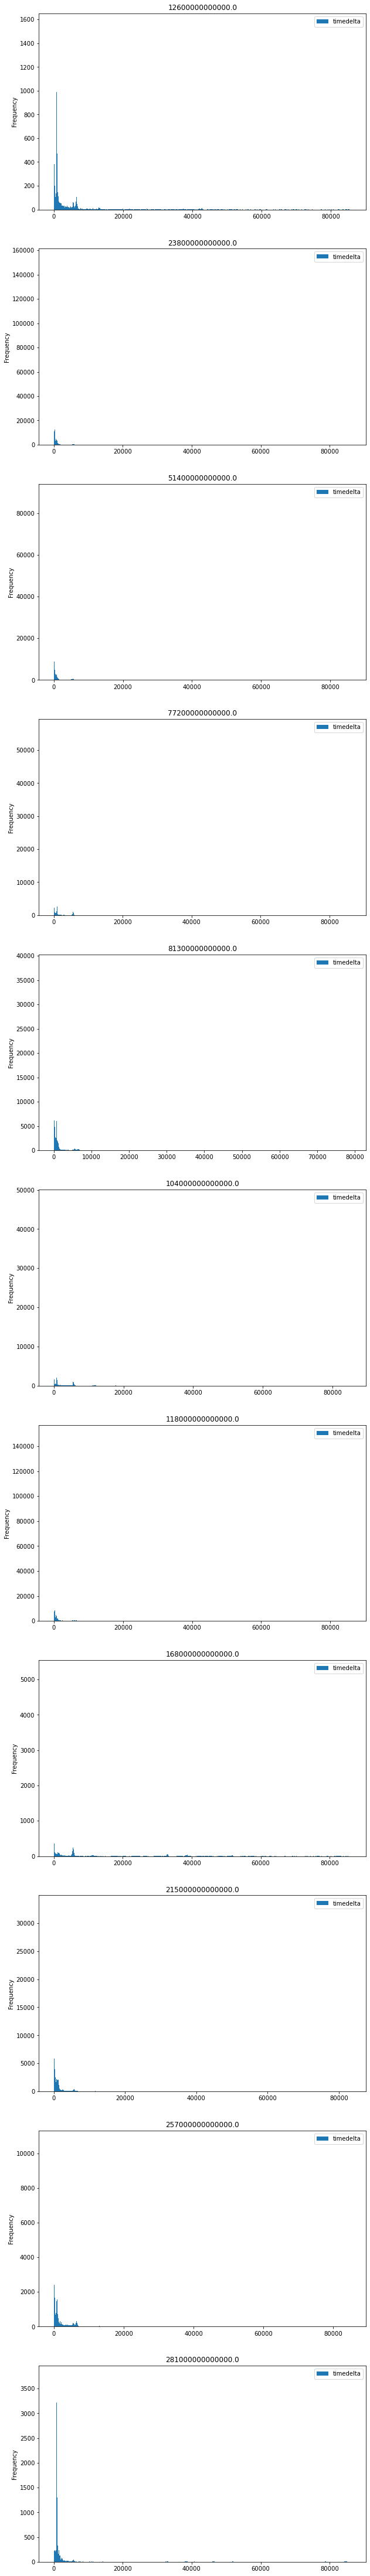

In [11]:
ax = df_data.plot.hist(column=["timedelta"], by="vessel_num", figsize=(10, 80), bins=1000)